In [1]:
from math import exp 
import numpy as np
from itertools import product
from copy import deepcopy

In [267]:
class Cell:
    def __init__(self,car_num = 0, av_num = 0, length = 0.2 , q_max = 1600, f_speed = 40, dt = 10, jam_density = 240, av_lane = 0,scale_down = 1):
        """
        f_speed: km/h; length: km; jam_density: veh/km; q_max = veh/h
        """
        self.car_num = car_num; self.av_num = av_num
        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num

        self.length = length; self.f_speed = f_speed; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.dt = dt; self.jam_density = jam_density*(1+0.5*self.av_ratio)
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.av_lane = av_lane; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.demand = 0; self.supply = 0; self.density = self.car_num/self.length
        self.scale_down = scale_down; self.left_flow = 0
        self.right_flow = 0; self.down_flow = 0
        self.left_prob = 0; self.right_prob = 0
        self.down_prob = 0; self.left_in = 0
        self.right_in = 0; self.up_in = 0
        self.exp_right_flow = 0 # 拟向右换道车辆数
        self.exp_left_flow = 0 # 拟向左换道车辆数
        self.exp_down_flow = 0 # 拟向下游的车辆数

    def update_variable(self, left_num, right_num, down_num, right_av_lane, left_av_lane, down_av_lane):
        """
        :param left_num: 左侧元胞车辆数
        :param right_num: 右侧元胞车辆数
        :param down_num: 下游元胞车辆数
        :return: 
        """
        beta1 = -0.4; beta2 = 5; beta3 = -0.1; beta4 = 1
        self.density = self.car_num/self.length
        self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600 # 这个改动较大
        self.demand = max(0, min(self.q_max,self.wave_speed*(self.jam_density-self.density)))*self.dt/3600

    
        left_utility = beta1*(self.car_num-left_num)+beta2
        right_utility = beta1*(self.car_num-right_num) + beta2  
        down_utility = beta3*(self.car_num-down_num)  + beta4 - 0.4*max(0,16-down_num)
        
        print(self.car_num)
        self.left_prob = exp(-left_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        self.right_prob = exp(-right_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        self.down_prob =  exp(-down_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        # print(self.down_prob)
        self.exp_down_flow = self.down_prob*self.supply
        self.exp_right_flow = self.right_prob*self.supply # 本车道拟向右换道车辆数
        self.exp_left_flow = self.left_prob*self.supply # 本车道拟向右换道车辆数
        
        if self.av_lane:
            self.right_prob = 1-self.av_ratio
            self.down_prob = self.av_ratio
        if right_av_lane: # 此处假设只有一个车道是自动驾驶车道，当然也可以假设很多，按照比例分配即可，但是现实可能不太好操作
            self.exp_right_flow = self.av_num
        if left_av_lane:
            self.exp_left_flow = self.av_num
        
        if down_av_lane: # 如果下游是自动驾驶车道，只有自动驾驶车才能往下走,剩下的车按比例换道
            self.exp_down_flow = self.av_num
            self.exp_right_flow = self.right_prob*(self.supply-self.av_num)
            self.exp_left_flow = self.left_prob*(self.supply-self.av_num)


    def update_car_num(self,up_out,down_demand,left_lane_up_out,left_lane_demand,right_lane_up_out,right_lane_demand,right_lane_exp_left_flow,left_lane_exp_right_flow,right_two_lane_exp_left_flow,left_two_lane_exp_right_flow,up_av_ratio, left_av_ratio, right_av_ratio):
        """
        Args:
            right_av_ratio: 
            up_out: 上游元胞想要出来的车辆数
            down_demand: 下游元胞的需求
            left_lane_up_out: 左侧上游想要直行的车辆数
            left_lane_demand: 左侧元胞供给
            right_lane_up_out: 右侧上游想要直行的车辆数
            right_lane_demand: 右侧元胞供给
            right_lane_exp_left_flow: 右侧想要变道的车辆数
            left_lane_exp_right_flow: 左侧想要变道的车辆数
            right_two_lane_exp_left_flow: 右侧第二个车道往右侧车道换道的车辆数
            left_two_lane_exp_right_flow: 左侧第二个车道往左侧车道换道的车辆数
            up_av_ratio: 
            left_av_ratio: 

        Returns:
        """
        #-----------自动驾驶车道有所不同的点：
        if self.av_lane:
            down_demand  = min(down_demand,self.av_num)
            
        
        
        
        # 三个cell进来的车辆数 上游cell 左侧车道的cell 右侧车道的cell
        self.up_in = min(self.demand,up_out) # 当前车道上游元胞向下走的车辆数
        if right_lane_exp_left_flow+left_lane_exp_right_flow>0:          
            self.right_in = min(right_lane_exp_left_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), right_lane_exp_left_flow)
            self.left_in = min(left_lane_exp_right_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), left_lane_exp_right_flow)
        else:
            self.right_in = 0; self.left_in = 0
       # 需要根据有多少车换道、直行到当前cell来确定换道对supply的影响；目的：体现出换道多交通的负效用
        if self.right_in+self.left_in+self.up_in>0:
            lc_ratio = (self.right_in+ self.left_in)/(self.right_in+self.left_in+self.up_in)
        else:
            lc_ratio = 0
        self.demand = self.demand * (1-lc_ratio*0.2) # 举例子
      # --------------------------------------------------------------------
        
        
        right_up_in = min(right_lane_demand, right_lane_up_out) # 右侧车道元胞直行车辆数
        left_up_in = min(left_lane_demand, left_lane_up_out) # 左侧车道元胞直行车辆数

        # 本cell朝三个方向出去的车辆数
        self.down_flow = min(down_demand,self.down_prob*self.car_num)
        if self.exp_right_flow+right_two_lane_exp_left_flow >0:
            self.right_flow = min(self.exp_right_flow/(self.exp_right_flow+right_two_lane_exp_left_flow)*(right_lane_demand-right_up_in) , self.exp_right_flow)
        else:
            self.right_flow = 0
        
        if self.exp_left_flow+left_two_lane_exp_right_flow > 0:
            self.left_flow = min(self.exp_left_flow/(self.exp_left_flow+left_two_lane_exp_right_flow)*(left_lane_demand-left_up_in) , self.exp_left_flow)
        else:
            self.left_flow = 0

            
    
    # 更新该元胞内部车辆数
        self.car_num = self.car_num + self.up_in + self.right_in + self.left_in - self.right_flow - self.down_flow - self.left_flow
        
        
        if not self.av_lane:
            self.av_num = (self.car_num-self.right_flow-self.down_flow-self.right_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in*right_av_ratio + self.left_in*left_av_ratio 
        else:
            self.av_num = (self.car_num-self.down_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in

        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num
            
        
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.q_max = self.q_max*(1+0.5*self.av_ratio)
        # print(self.car_num)

class source:
    def __init__(self,car_num,av_num , q_max=1600,f_speed = 40,length = 0.2,dt = 10):
            self.car_num = car_num
            self.length = length
            self.q_max = q_max
            self.f_speed = f_speed
            self.density = self.car_num/self.length
            self.dt = dt
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
            self.exp_down_flow = self.supply # source只往下走，不换道，因此，期望能往下的流量就是他的供给
            self.down_flow = self.supply # 实际的流量初始化是不知道的，是和下游相关的，需要update_variable
            self.av_num = av_num
            self.av_ratio = self.av_num/self.car_num
        
        
    def update_variable(self,input_flow, av_input,down_demand):
            self.down_flow = min(self.supply, down_demand)
            self.car_num = self.car_num + input_flow - self.down_flow
            self.av_num = self.av_num + av_input - self.down_flow*self.av_ratio
            self.av_ratio = self.av_num/self.car_num
            self.density = self.car_num/self.length
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
           
        

class sink:
    def __init__(self,av_num):
        self.car_num = 0
        self.demand = 100000000000
        self.av_ratio = 0
        self.av_lane = 0
        self.av_num = av_num



In [268]:
class Agent():
    def __init__(self,lane_num, cell_num, ini_num, ini_av, ini_action, sim_time_step,sys_time,input,av_input): # 注意初始化的av_num
        """
        :param lane_num: 研究的范围内多少条道路
        :param cell_num: 研究范围内没条道路多少个cell
        :param initial_num: 每一个cell一开始多少车辆数，比如我们仿真8:00-8:30，或者仿真8:30-9:00这个值不一样
        :param initial_action: 这个是说的哪些segement是av dedicated lane
        :param simulation_time: 仿真多少个时间步
        :param input: 输入流量
        """
        self.lane_num = lane_num
        self.cell_num = cell_num
        self.ini_num = ini_num
        self.ini_action = ini_action
        self.sim_time_step = sim_time_step
        self.state1 = 0 # 这些状态自己定义哈
        self.state2 = 0
        self.state3 = 0
        self.reward = 0 # reward自己定义
        self.done = False # 是否结束
        self.sys_time = sys_time
        self.num_record = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.av_ratio_record  = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.av_num_record = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.input = input # input 应该是lane num * time step的东西
        self.av_input = av_input

    def run(self):
        # 初始化网络----------------------------------------------------------------
        Road = [[[] for j in range(self.cell_num)] for i in range(self.lane_num)]
        for i,j in product(range(self.lane_num),range(self.cell_num-2)):
            Road[i][j+1] = Cell(car_num = ini_num[i][j+1],av_lane=self.ini_action[i][j+1],av_num= ini_av[i][j+1])
      
        for i in range(self.lane_num):
            Road[i][0] = source(car_num=ini_num[i][0],av_num=ini_av[i][0])
            Road[i][-1] = sink(av_num = ini_av[i][-1])
        # -------------------------------------------------------------------------

        for t in range(self.sim_time_step):
            Road_copy = deepcopy(Road) # 在更新过程中有一些先后顺序，需要破坏Road的性质，因此先拷贝一份,因为要改变Road部分元素，所以要用deepcopy
            for i,j in product(range(self.lane_num),range(self.cell_num)):
                self.num_record[i][j][t] = Road_copy[i][j].car_num
                self.av_ratio_record[i][j][t] = Road_copy[i][j].av_ratio
                self.av_num_record[i][j][t] = Road_copy[i][j].av_num
                
            
            for i in range(self.lane_num):
                Road[i][0].update_variable(input_flow = input[i][t],down_demand = Road[i][1].demand,av_input = av_input[i][t]) # 此处用Road和Road_copy并无区别，暂且用Road
                
                for _j in range(self.cell_num-2):
                    j = _j + 1
                    if i == 0:
                        Road[i][j].update_variable(left_num = 0,right_num=Road_copy[i+1][j].car_num,down_num=Road_copy[i][j+1].car_num,right_av_lane = Road_copy[i+1][j].av_lane,left_av_lane = 0,down_av_lane =  Road_copy[i][j+1].av_lane)
                        
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                                  down_demand = Road_copy[i][j+1].demand,
                                                                  left_lane_up_out = 0,
                                                                  left_lane_demand = 0,
                                                                  right_lane_up_out = Road_copy[i+1][j-1].down_flow,
                                                                  right_lane_demand = Road_copy[i+1][j].demand,
                                                                  right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                                  left_lane_exp_right_flow = 0,
                                                                  right_two_lane_exp_left_flow = Road_copy[i+2][j].exp_left_flow,
                                                                  left_two_lane_exp_right_flow = 0,
                                                                  up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                                  left_av_ratio = 0,
                                                                  right_av_ratio = Road_copy[i+1][j].av_ratio)
                    if i == 1:
                        Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,right_num=Road_copy[i+1][j].car_num,down_num=Road_copy[i][j+1].car_num,right_av_lane = Road_copy[i+1][j].av_lane,left_av_lane = Road_copy[i-1][j].av_lane,down_av_lane =  Road_copy[i][j+1].av_lane)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = Road_copy[i+1][j-1].down_flow,
                                                              right_lane_demand = Road_copy[i+1][j].demand,
                                                              right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = 0,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = Road_copy[i+1][j].av_ratio)
                    if i == 2:
                        Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,right_num=0,down_num=Road_copy[i][j+1].car_num, right_av_lane =0,left_av_lane = Road_copy[i-1][j].av_lane,down_av_lane =  Road_copy[i][j+1].av_lane)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = 0,
                                                              right_lane_demand = 0,
                                                              right_lane_exp_left_flow = 0,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = Road_copy[i-2][j].exp_right_flow,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = 0)
                              
                             

In [269]:
ini_num = np.random.poisson(20 , size=(3, 100))
ini_av = np.random.poisson(10 , size=(3, 100))
for i,j in product(range(3),range(100)):
    ini_av[i][j] = min(ini_av[i][j],ini_num[i][j])
    
ini_action = np.zeros([3,100])
for j in range(100):
    ini_action[0][j] = 1
    


input = np.random.poisson(10 , size=(3, 100)) # 道路和时间

p = 0.4
av_input = np.random.poisson(10*p , size=(3, 100))
for i,t in product(range(3),range(100)):
    av_input[i][t] = min(av_input[i][t],input[i][t])




In [270]:
agent = Agent(lane_num=3,cell_num=100,ini_num = ini_num,ini_av=ini_av,ini_action = ini_action,sim_time_step=100,sys_time=0,input=input,av_input = av_input)


In [271]:
agent.run()

17
15
16
15
16
20
18
20
17
21
17
22
17
20
14
20
13
26
17
21
21
23
15
18
18
18
19
17
20
23
17
14
13
18
16
19
17
23
18
20
14
16
25
15
23
22
23
23
18
18
16
17
25
16
22
16
25
18
21
21
22
22
18
26
19
19
11
16
24
22
22
14
18
20
21
22
18
19
26
24
19
21
24
23
21
21
30
24
28
20
25
18
21
16
30
23
14
19
14
25
21
19
22
26
14
16
24
11
11
23
16
20
22
26
23
22
16
18
18
23
23
15
15
17
14
27
13
15
13
21
17
21
18
25
19
18
17
23
21
16
21
23
22
22
25
21
17
25
21
17
16
30
21
19
18
18
25
19
22
19
26
15
13
20
18
14
15
14
14
18
22
14
15
22
17
18
16
17
12
14
23
12
20
14
21
25
24
17
22
19
26
21
18
17
20
22
22
19
26
17
19
14
17
18
22
18
20
28
22
17
25
24
13
20
16
25
28
26
12
15
24
19
20
20
27
17
24
25
23
24
19
21
18
24
33
14
18
19
15
34
21
19
16
26
20
19
26
24
24
17
20
15
23
21
16
20
24
29
25
14
16
23
20
24
15
15
26
17
23
19
15
22
14
13
24
24
17
17
16
20
21
20
20
18
23
24
29
22
20
23
19
16
17
20
21.444444444444443
15
16
15
16
20
18
20
17
21
17
22
17
20
14
20.0
13
26
17
21
21
23
15
18
18
18
19
17
20
23
17
14
13
1

OverflowError: math range error

In [272]:
import matplotlib.pyplot as plt 

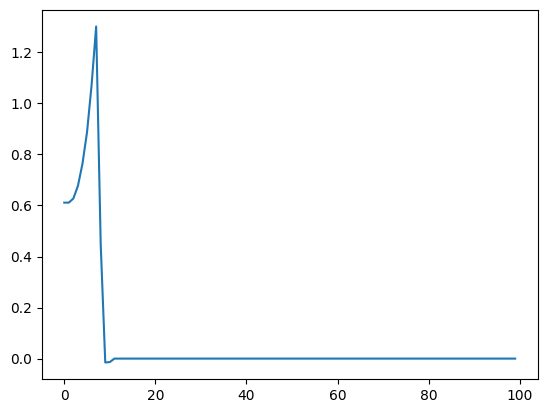

In [260]:
plt.plot(agent.av_ratio_record[0][0:99][90])
# plt.hlines(48,0,100,color='red',ls = '--')
# plt.hlines(25,0,100,color='blue',ls='-.')

In [261]:
agent.num_record[1]

array([[2.10000000e+01, 3.20000000e+01, 3.71414141e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.20000000e+01, 2.58585859e+01, 2.39921071e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.80000000e+01, 1.80000000e+01, 1.87615928e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.80000000e+01, 1.80000000e+01, 1.82035192e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.60000000e+01, 1.23022259e-03, 7.48089908e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [232]:
agent.av_num_record[0]

array([[  0.        ,   6.        ,   6.66666667, ..., 214.45416318,
        215.67144341, 217.91331524],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [222]:
supply = []
demand = []
q = int(1600*1.5)
jam = int(240*1.5)
w = q/(jam-q/40)
for i in range(0,jam):
    k = i 
    supply.append(min(q,40*k))
    demand.append(min(q,w*(jam-k)))
# supply =max(0, min(self.q_max,1000*self.density * self.f_speed * self.dt / 3600)* self.length/1000)
#     self.demand =max(0, min(self.q_max,1000*(self.jam_density - self.density) * self.wave_speed * self.dt / 3600) * self.length/1000)


# self.q_max/(self.jam_density-self.q_max/self.f_speed)


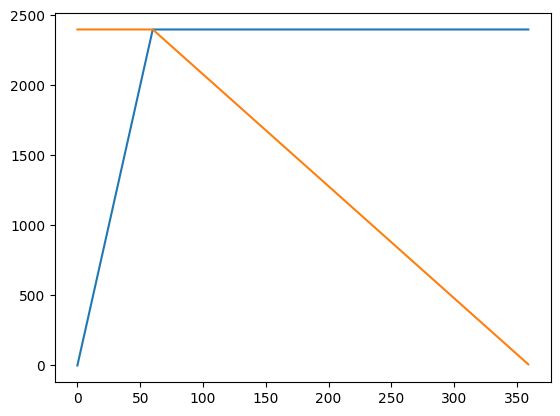

In [223]:
plt.plot(supply)

plt.plot(demand)

In [9]:
print(b)

[1, 2, 3]
